In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import os
import seaborn as sns
import itertools

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from tqdm import tqdm
import warnings
#ignore the warnings about not having different language fonts available 
warnings.filterwarnings(action='ignore') 

import logging
logger = logging.getLogger('ftpuploader')

### Data Exploration and Processing

In [2]:
#load data and downcast to integers
orig_train = pd.read_csv('/Users/christinejiang/Documents/Python/data/train_1.csv')
key = pd.read_csv('/Users/christinejiang/Documents/Python/data/key_1.csv')
submission = pd.read_csv('/Users/christinejiang/Documents/Python/data/sample_submission_1.csv')
train = orig_train.fillna(0)
for col in train.columns[1:]:
    train[col] = pd.to_numeric(train[col], downcast = 'integer')

In [5]:
def find_lang(page):
    match = re.search('[a-z][a-z].wikipedia.org', page)
    if match:
        return match.group(0)[0:2]
    return 'na'

def find_article(page):
    match = re.search('[a-z][a-z].wikipedia.org.', page)
    if match:
        article_end = match.start()-1
        return(page[0:article_end])
    return 'na'

def find_access(page):
    match = re.search('.*.wikipedia.org.', page)
    if match:
        access_start = match.end()
        return(page[access_start:])
    return 'na'

train['Language'] = train['Page'].map(find_lang)
train['Article'] = train['Page'].map(find_article)
train['Access'] = train['Page'].map(find_access)

In [6]:
dates = train.iloc[:,1:551]
labels = train[['Article','Language','Access','Page']]
newtrain = pd.concat([labels, dates], axis = 1)

display(newtrain.head(2))
newtrain['Total'] = newtrain.sum(axis=1)
newtrain['Language'].value_counts().sort_values(ascending=False)

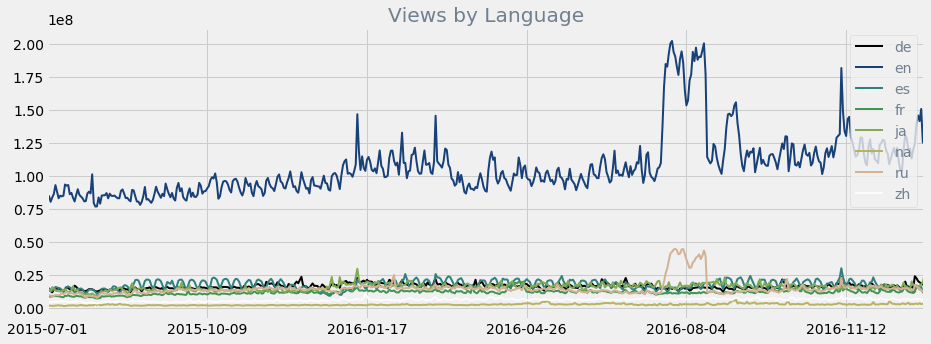

In [8]:
#plot the total views per language
def plot_groups(df, groupby):
    plt.style.use('fivethirtyeight')
    group = df.groupby(groupby).sum().reset_index()
    transpose = group.T
    transpose = transpose.rename(columns = transpose.iloc[0]).drop(transpose.index[0])
    figure = transpose.plot(figsize=(14,5), use_index = True, colormap = "gist_earth", lw=2)
    title=plt.title('Views by '+str(groupby), color='slategray')
    plt.legend(loc='upper left')
    plt.setp(plt.legend().get_texts(), color='slategray')
    return transpose

transposed = plot_groups(newtrain, 'Language')

In [43]:
#get random indices to plot
languages = newtrain['Language'].unique()
indices = np.random.randint(1,1400,size=3)
num_results = len(indices)
print(indices)

[1374  591  690]


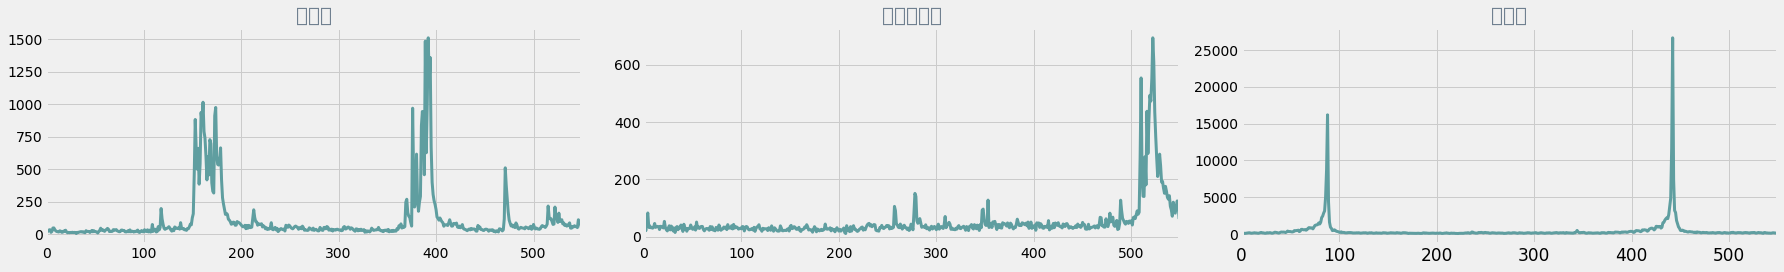

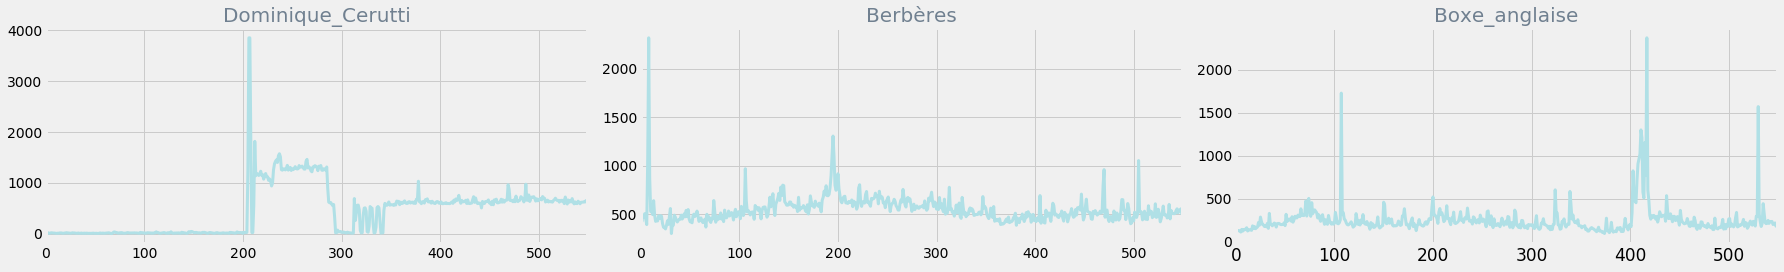

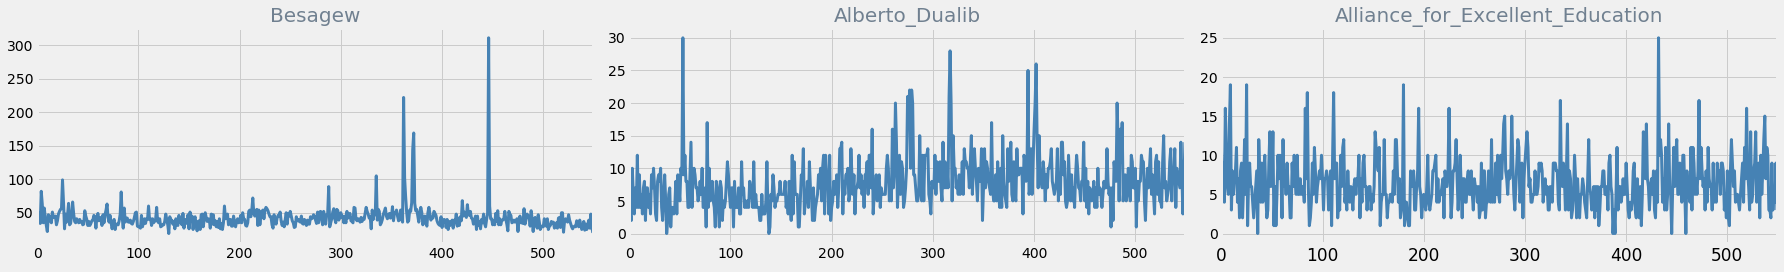

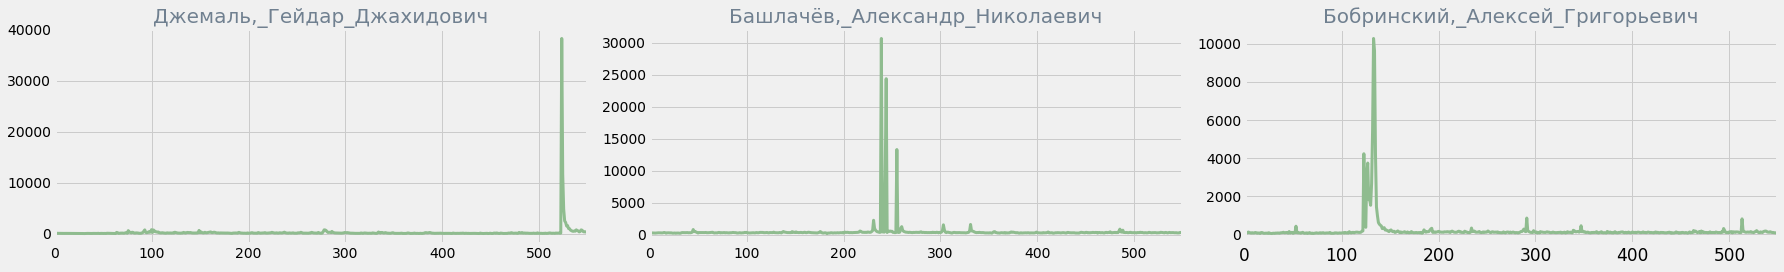

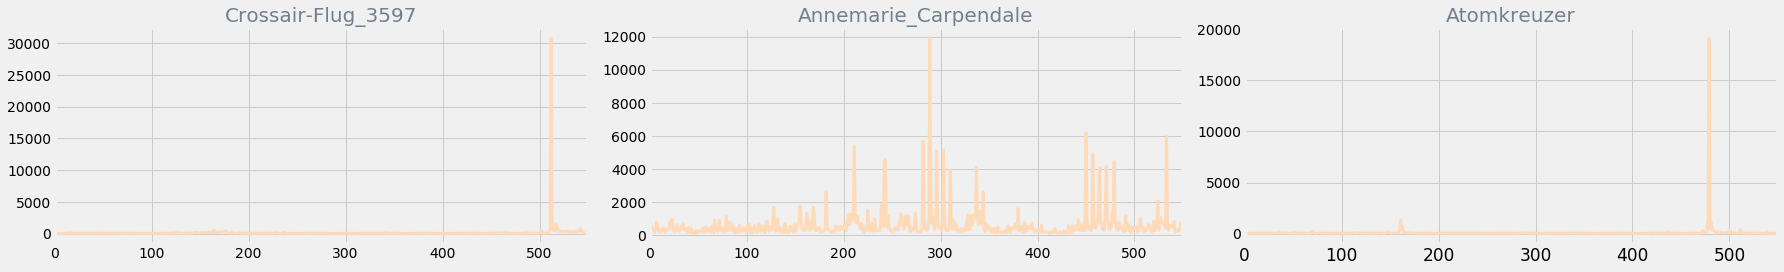

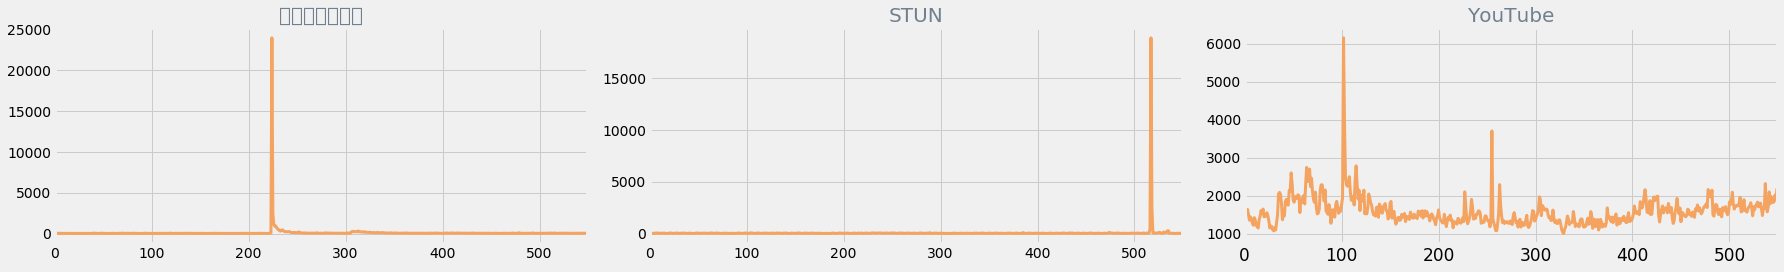

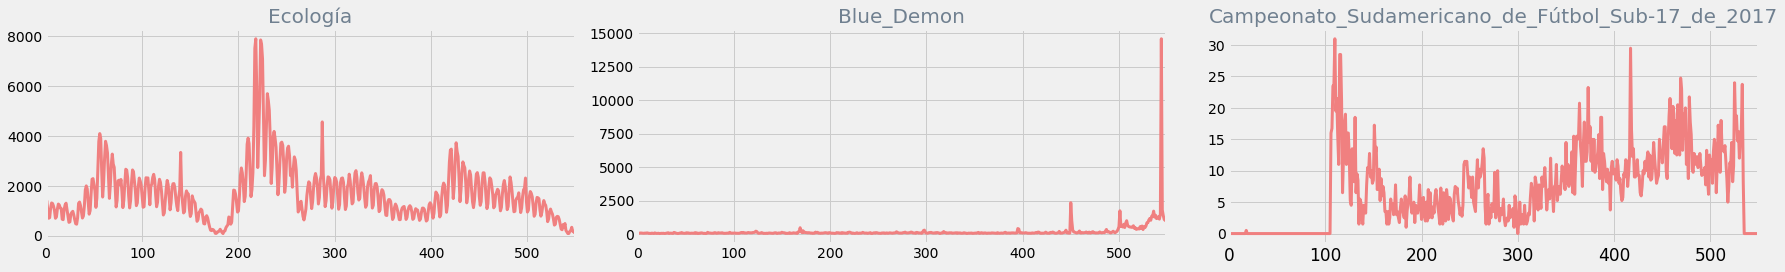

In [55]:
#plot a sample of pages for each language
colors = ['cadetblue','powderblue','steelblue','yellowgreen','darkseagreen','peachpuff','sandybrown','lightcoral']
dataframedict = {}
for i,language in enumerate(languages):
    dataframedict[language] = newtrain[newtrain['Language']==language]
    if language != 'na':
        langcolor = colors[i]
        fig, subaxes = plt.subplots(1,num_results,figsize=[25,4])
        pivottable = dataframedict[language].pivot_table(columns='Article')
        for i, index in enumerate(indices):
            singlerecord = pivottable.iloc[:,index]
            plt.xticks(fontsize=17)
            sns.tsplot(singlerecord,ax = subaxes[i],color=langcolor, linewidth=3)
            subaxes[i].set_title(singlerecord.name, color='slategray')
            subaxes[i].title.set_size(20)
            #fig.suptitle(language)
            plt.tight_layout()
    dataframedict[language]['Total'] = dataframedict[language].sum(axis=1)


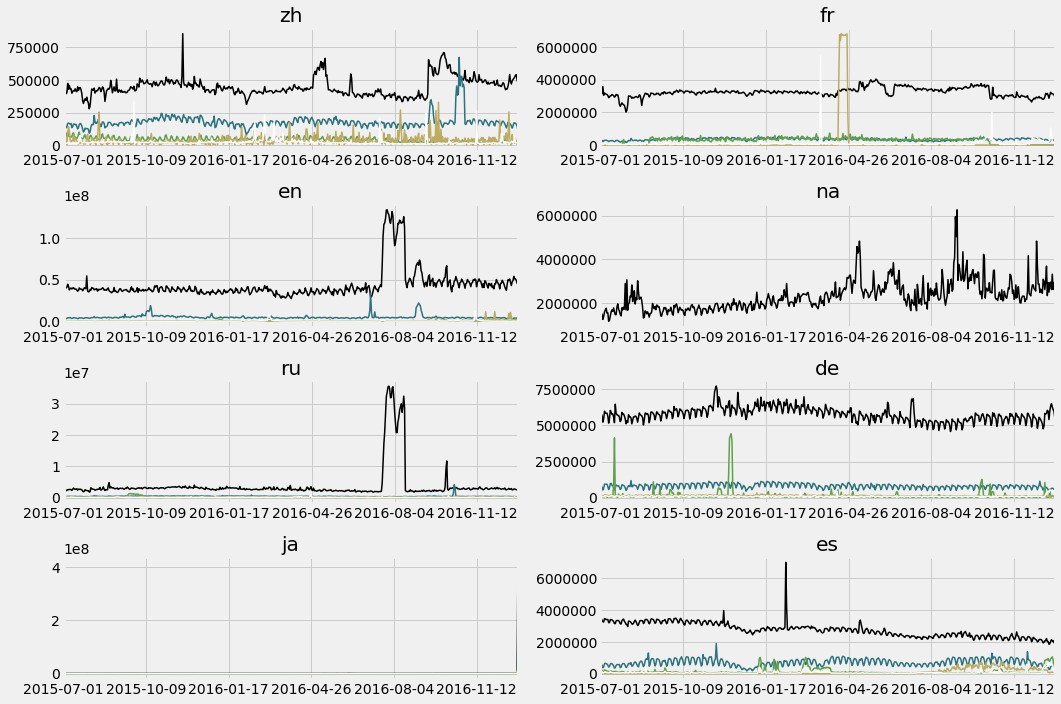

In [952]:
#plot top 5 pages for every language
fig, subaxes = plt.subplots(4,2,figsize=(15,10))
subaxes = subaxes.flatten()
x = [[a,b] for a in range(0,4) for b in range(0,2)]
for i,language in enumerate(languages):
    total_hits = dataframedict[language].groupby('Article').sum()
    top5sites = total_hits.nlargest(5, 'Total')
    axis = subaxes[x[i]]
    top5sites.T.iloc[:-1].plot(lw=1.5, ax=subaxes[i], colormap = 'gist_earth')
    subaxes[i].get_legend().remove()
    subaxes[i].set_title(language)
plt.tight_layout()

In [888]:
x = [[a,b] for a in range(0,4) for b in range(0,2)]
x[0]

[0, 0]

### Time Series Modeling

In [767]:
top5sites

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,2015-08-09,2015-08-10,2015-08-11,2015-08-12,2015-08-13,2015-08-14,2015-08-15,2015-08-16,2015-08-17,2015-08-18,2015-08-19,2015-08-20,2015-08-21,2015-08-22,2015-08-23,2015-08-24,2015-08-25,2015-08-26,2015-08-27,2015-08-28,2015-08-29,2015-08-30,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-05,2015-09-06,2015-09-07,2015-09-08,2015-09-09,2015-09-10,2015-09-11,2015-09-12,2015-09-13,2015-09-14,2015-09-15,2015-09-16,2015-09-17,2015-09-18,2015-09-19,2015-09-20,2015-09-21,2015-09-22,2015-09-23,2015-09-24,2015-09-25,2015-09-26,2015-09-27,2015-09-28,2015-09-29,2015-09-30,2015-10-01,2015-10-02,2015-10-03,2015-10-04,2015-10-05,2015-10-06,2015-10-07,2015-10-08,2015-10-09,2015-10-10,2015-10-11,2015-10-12,2015-10-13,2015-10-14,2015-10-15,2015-10-16,2015-10-17,2015-10-18,2015-10-19,2015-10-20,2015-10-21,2015-10-22,2015-10-23,2015-10-24,2015-10-25,2015-10-26,2015-10-27,2015-10-28,2015-10-29,2015-10-30,2015-10-31,2015-11-01,2015-11-02,2015-11-03,2015-11-04,2015-11-05,2015-11-06,2015-11-07,2015-11-08,2015-11-09,2015-11-10,2015-11-11,2015-11-12,2015-11-13,2015-11-14,2015-11-15,2015-11-16,2015-11-17,2015-11-18,2015-11-19,2015-11-20,2015-11-21,2015-11-22,2015-11-23,2015-11-24,2015-11-25,2015-11-26,2015-11-27,2015-11-28,2015-11-29,2015-11-30,2015-12-01,2015-12-02,2015-12-03,2015-12-04,2015-12-05,2015-12-06,2015-12-07,2015-12-08,2015-12-09,2015-12-10,2015-12-11,2015-12-12,2015-12-13,2015-12-14,2015-12-15,2015-12-16,2015-12-17,2015-12-18,2015-12-19,2015-12-20,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-26,2015-12-27,2015-12-28,2015-12-29,2015-12-30,2015-12-31,2016-01-01,2016-01-02,2016-01-03,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-09,2016-01-10,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,2016-01-16,...,2016-06-16,2016-06-17,2016-06-18,2016-06-19,2016-06-20,2016-06-21,2016-06-22,2016-06-23,2016-06-24,2016-06-25,2016-06-26,2016-06-27,2016-06-28,2016-06-29,2016-06-30,2016-07-01,2016-07-02,2016-07-03,2016-07-04,2016-07-05,2016-07-06,2016-07-07,2016-07-08,2016-07-09,2016-07-10,2016-07-11,2016-07-12,2016-07-13,2016-07-14,2016-07-15,2016-07-16,2016-07-17,2016-07-18,2016-07-19,2016-07-20,2016-07-21,2016-07-22,2016-07-23,2016-07-24,2016-07-25,2016-07-26,2016-07-27,2016-07-28,2016-07-29,2016-07-30,2016-07-31,2016-08-01,2016-08-02,2016-08-03,2016-08-04,2016-08-05,2016-08-06,2016-08-07,2016-08-08,2016-08-09,2016-08-10,2016-08-11,2016-08-12,2016-08-13,2016-08-14,2016-08-15,2016-08-16,2016-08-17,2016-08-18,2016-08-19,2016-08-20,2016-08-21,2016-08-22,2016-08-23,2016-08-24,2016-08-25,2016-08-26,2016-08-27,2016-08-28,2016-08-29,2016-08-30,2016-08-31,2016-09-01,2016-09-02,2016-09-03,2016-09-04,2016-09-05,2016-09-06,2016-09-07,2016-09-08,2016-09-09,2016-09-10,2016-09-11,2016-09-12,2016-09-13,2016-09-14,2016-09-15,2016-09-16,2016-09-17,2016-09-18,2016-09-19,2016-09-20,2016-09-21,2016-09-22,2016-09-23,2016-09-24,2016-09-25,2016-09-26,2016-09-27,2016-09-28,2016-09-29,2016-09-30,2016-10-01,2016-10-02,2016-10-03,2016-10-04,2016-10-05,2016-10-06,2016-10-07,2016-10-08,2016-10-09,2016-10-10,2016-10-11,2016-10-12,2016-10-13,2016-10-14,2016-10-15,2016-10-16,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31,2016-11-01,2016-11-02,2016-11-03,2016-11-04,2016-11-05,2016-11-06,2016-11-07,2016-11-08,2016-11-09,2016-11-10,2016-11-11,2016-11-12,2016-11-13,2016-11-14,2016-11-15,2016-11-16,2016-11-17,2016-11-18,2016-11-19,2016-11-20,2016-11-21,2016-11-22,2016-11-23,2016-11-24,2016-11-25,20

In [982]:
#try multiple arima models
#plot the predictions of the top 5 models
#return a df with the aic and mean squared errors of the top 5 models
class TimeSeries:
    def __init__(self, ts):
        self.ts = ts
        self.df = pd.DataFrame(ts).rename(columns={0:'Hits'})
        self.adf_statistic = self.stationarity_check()[0]
        self.pvalue = self.stationarity_check()[1]
        self.stationary = self.stationarity_check()[2]
        self.train, self.test = self.train_test_split()
        #self.aics = self.arima_model()
        
    def stationarity_check(self):
        ts = self.ts
        stationarity = adfuller(ts)
        adf_statistic = stationarity[0]
        pvalue = stationarity[1]
        if stationarity[0] < stationarity[4]['5%']:
            stationary = True
        else:
            stationary = False
        return adf_statistic, pvalue, stationary
    
    def plot_acf_pacf(self, diffs=1):
        if diffs == False:
            figure, axes = plt.subplots(1, 2, figsize = (13,2))
            plot_acf(timeseries.ts, ax=axes[0],lw=2)
            axes[0].set_title('ACF_No_Lag')
            plot_acf(timeseries.ts, title = 'PACF_No_Lag', ax=axes[1], lw=2)
            axes[1].set_title('PACF'+str(diffs))
        else:
            figure, axes = plt.subplots(1, 2, figsize = (13,2))
            ts = self.ts
            df_lag = ts.diff(periods=diffs)
            plot_acf(df_lag[diffs:], ax=axes[0],lw=2)
            axes[0].set_title('ACF_Lag'+str(diffs))
            plot_acf(df_lag[diffs:], title = 'PACF Lag_' + str(diffs), ax=axes[1], lw=2)
            axes[1].set_title('PACF'+str(diffs))
        
    def train_test_split(self, test_split=0.75):
        df = self.df
        marker = int(df.shape[0]*test_split)
        train = df.iloc[0:marker]
        test = df.iloc[marker:]
        return train, test
    
    def arima_model(self, pdq_max=4):
        train = self.train
        p=q=d=range(0,pdq_max)
        pdq = list(itertools.product(p,d,q))
        aics = {}
        best_aic = 9999
        for param in pdq:
            try:
                arima = ARIMA(train, order = param).fit()
                aics[param] = arima.aic
            except Exception as e: 
                aics[param] = e
                continue
        return aics
    
    def plot_predictions(self,p,d,q):
        df = self.df
        train = self.train
        test = self.test
        arima = ARIMA(train, order = (p,d,q)).fit()
        display(arima.summary())
        
        predicted = arima.forecast(test.shape[0])[0]
        squarederror = mean_squared_error(test, predicted)
        mean_error = np.sqrt(squarederror)
        display(mean_error)
    
        predictions = arima.predict(start=d, end=599, typ='levels')
        fig = predictions.plot(lw=2, color ='darkseagreen')
        train.plot(lw=2, ax=fig, color ='lightcoral')
        test.plot(lw=3, ax=fig, color ='powderblue')
        
    def plot_rolling(self, n=12):
        ts = self.ts
        fig, axes = plt.subplots(1,figsize=(10,4))
        ts.rolling(n).std().plot(color='darkseagreen', ax=axes, lw=2)
        ts.plot(ax=axes, color='lightcoral', lw=2)
        ts.rolling(n).mean().plot(ax=axes, lw=2)
        plt.title('Time Series with Rolling Statistics')
        legend = axes.legend(['Rolling Std.','Original','Rolling Avg.'])
        

In [986]:
def make_df(article):
    totals = newtrain[newtrain['Article']==article].sum()
    rows = totals[4:].astype(float)
    rows.index = pd.DatetimeIndex(rows.index)
    return rows

myseries = make_df('Dog')
# Bill_Nye
# Charlize_Theron
# Dog
# Serena_Williams
# United_Nations
# Tesla_Motors

In [996]:
timeseries = TimeSeries(myseries)
#aics = timeseries.arima_model()

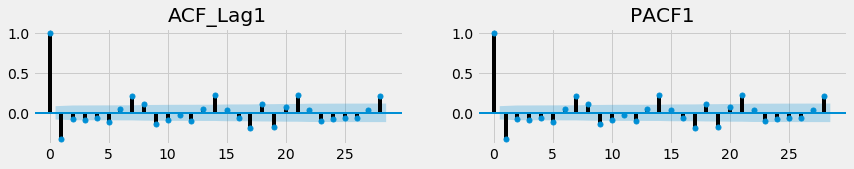

In [1002]:
timeseries.plot_acf_pacf(1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.Hits   No. Observations:                  411
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -3882.356
Method:                       css-mle   S.D. of innovations           3056.436
Date:                Thu, 27 Feb 2020   AIC                           7778.713
Time:                        22:10:21   BIC                           7806.843
Sample:                    07-02-2015   HQIC                          7789.841
                         - 08-15-2016                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.5629     18.090     -0.142      0.887     -38.019      32.894
ar.L1.D.Hits     0.6237      0.125      4.974      0.000       0.378       0.869
ar.L2.D.Hits    -0.1433      0.063     -2.268      0.024      -0.267      -0.019
ar.L3.D.Hits    -0.1615      0.057     -2.840      0.005      -0.273      -0.050
ma.L1.D.Hits    -1.3675      0.120    -11.440      0.000      -1.602      -1.133
ma.L2.D.Hits     0.4480      0.110      4.068      0.000       0.232       0.664
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0205           -1.0360j            1.4542           -0.1262
AR.2            1.0205           +1.0360j            1.4542            0.1262
AR.3           -2.9286           -0.0000j            2.9286           -0.5000
MA.1            1.2145           +0.0000j            1.2145            0.0000
MA.2            1.8379           +0.0000j            1.8379            0.0000
-----------------------------------------------------------------------------
"""

3309.288935876229

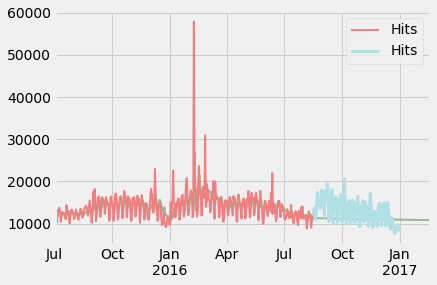

In [1008]:
timeseries.plot_predictions(3,1,2)

In [995]:
myseries['2016-03-03 00:00:00']

15588.0

In [1009]:
timeseries.test

,Hits
2016-08-16,13517.0
2016-08-17,12016.0
2016-08-18,12416.0
2016-08-19,13858.0
2016-08-20,10830.0
2016-08-21,12149.0
2016-08-22,14822.0
2016-08-23,17412.0
2016-08-24,15477.0
2016-08-25,15528.0


In [1010]:
#to do:
#implement median and average forecasts
#implement evaluation metrics function: mean error, mape, aic
#implement way to plot top 3 models
#understand SARIMA?
#use auto_arima?